In [188]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import numpy as np
import torch.utils.data as utils
from torch.utils.data import DataLoader
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score
from torch.utils.data import Subset
from torchvision import  transforms
import pickle as pkl
from os.path import join as oj
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import argparse
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
from tqdm import tqdm
sys.path.append('../fit/')
import cd
import sys
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
from copy import deepcopy
import pandas as pd
import seaborn as sns
sns.set()
import torch.nn.functional as F
from os.path import join as oj
pd.set_option('precision', 2)
%matplotlib inline

In [212]:
save_path = "../../results_for_export"
trained_model_folder = '../skin_cancer/feature_models/'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder) if 'pkl'  in fname]) 
# other models were trained badly

results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects() 


/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [213]:
results['final_acc'] = [max(x) for x in results['val_acc_history']] #TODO change so it 
results['final_acc_train'] = [max(x)  for x in results['train_acc_history']]
results['AUC (no patches)'] =[0 for x in results['regularizer_rate']]
results['final_cd'] = [min(x) for x in results['train_cd_history']]
results['final_test_loss'] = [min(x) for x in results['val_loss_history']]
results['final_train_loss'] = [min(x) for x in results['train_loss_history']]
# results['regularizer_rate'][6] =-1
results = results.dropna()
results = results[results.learning_rate ==0.01]
results = results[results.momentum ==0.9]
results = results[results.batch_size ==16]

In [229]:
results[['regularizer_rate','final_acc', 'learning_rate','AUC (no patches)','seed']]

,regularizer_rate,final_acc,learning_rate,AUC (no patches),seed
5,-1.0,0.87,0.01,0.86,42
13,10.0,0.91,0.01,0.89,42
15,0.0,0.83,0.01,0.87,42


In [217]:

print(results[['regularizer_rate','final_acc', 'AUC (no patches)']].sort_values(by = ['regularizer_rate']).to_latex(index = False))

\begin{tabular}{rrr}
\toprule
 regularizer\_rate &  final\_acc &  AUC (no patches) \\
\midrule
             -1.0 &       0.87 &                 0 \\
              0.0 &       0.83 &                 0 \\
             10.0 &       0.91 &                 0 \\
\bottomrule
\end{tabular}



# Calculate ROC AUC

In [218]:
data_path = "../../../datasets"
save_path = oj(data_path, "ISIC_features")
from torch.utils.data import TensorDataset, ConcatDataset
with open(oj(save_path, "cancer.npy"), 'rb') as f:
    cancer_featuress = np.load(f)
with open(oj(save_path, "not_cancer.npy"), 'rb') as f:
    not_cancer_featuress = np.load(f)
    
cancer_targets = np.ones((cancer_featuress.shape[0])).astype(np.int64)
not_cancer_targets = np.zeros((not_cancer_featuress.shape[0])).astype(np.int64)
with open(oj(save_path, "not_cancer_cd.npy"), 'rb') as f:
    not_cancer_cd= np.load(f)
not_cancer_dataset = TensorDataset(torch.from_numpy(not_cancer_featuress).float(), torch.from_numpy(not_cancer_targets),torch.from_numpy(not_cancer_cd).float())

cancer_dataset = TensorDataset(torch.from_numpy(cancer_featuress).float(), torch.from_numpy(cancer_targets),torch.from_numpy(-np.ones((len(cancer_featuress), 2, 25088))).float())
complete_dataset = ConcatDataset((cancer_dataset, not_cancer_dataset))



num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(complete_dataset, [num_train, num_test, num_val])


datasets = {'train' : train_dataset, 'test':test_dataset, 'val': val_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset), 'val': len(val_dataset)}

In [238]:
val_filtered_dataset = torch.utils.data.Subset(complete_dataset, [idx for idx in val_dataset.indices if complete_dataset[idx][2][0,0] ==-1])

In [239]:
device = torch.device(0)
model = models.vgg16(pretrained=True)
# make conv untrainable - test if needed
model.classifier[-1] = nn.Linear(4096, 2)
model = model.classifier.to(device)

In [ ]:
def eval_model_on(model, dataset):
    val_filtered_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=True, num_workers=4)
    model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels, cd in val_filtered_dataloader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,0].detach().cpu().numpy())
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return 1-y, y_hat


In [ ]:
results_for_auc = results[['regularizer_rate','pid',]]
roc_curves = {}
f1_scores = {}
auc_scores = {}

auc_scorespid = {}
for index, row in results_for_auc.iterrows():

    with open(oj(trained_model_folder, str(row['pid']) + '.pt'), 'rb') as f:
        
        weights = torch.load(f)
    model.load_state_dict(weights)
    y, y_hat = eval_model_on(model, val_filtered_dataset)

    precision, recall, _ = roc_curve(y_hat, y)

    roc_curves[row['regularizer_rate']] = (precision, recall)
    auc_scores[row['regularizer_rate']] = roc_auc_score(y_hat, y)
    
    auc_scorespid[row['pid']] = roc_auc_score(y_hat, y)
    f1_scores[row['regularizer_rate']] = f1_score(y_hat, y > .8)

results['AUC (no patches)'] =[auc_scorespid[x] for x in results['pid']]

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

for key in roc_curves.keys():
    key_label = key
    if key == 10.0 or key == 0.0 or key == -1:
        if key ==-1:
            key_label  = "Excluded patches"

        ax.plot(roc_curves[key][1], 1-roc_curves[key][0], label = str(key_label) + " F1: "+ "{:2.2f}".format(f1_scores[key]))
ax.set_ylabel("Specificity");
ax.set_xlabel("Sensitivity");
fig.legend(loc=10)
fig.suptitle("Malignant tumor classification on filtered validation set")
save_path = "../results_for_export"
fig.savefig(oj(save_path, "with_reg"))

# With GradCAM

In [131]:
 results[['regularizer_rate','pid',]]

,regularizer_rate,pid
4,10.0,65522666016212743206
6,0.0,73007178261481664335


In [138]:
import sys
sns.reset_orig()
sys.path.append("../../pytorch-cnn-visualizations/src")
from gradcam import GradCam

In [139]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

In [140]:
os.path.isdir('../skin_cancer/feature_models')

True

In [150]:
import torchvision.models as models
from PIL import Image
device = torch.device("cuda")
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)

model = model.eval()


In [182]:
# load the two imgs
data_path = "../../../datasets"
img_path = oj(data_path, "ISIC/raw_data/not_cancer")
seg_path  = oj(data_path, "ISIC/segmentation")

In [183]:
img_name =os.listdir(seg_path)[30]
img = Image.open(oj(img_path, img_name))
img_np = np.asarray(img)/255.0
img.close()

In [184]:
def get_grad_cam(model, img):
    torch_img = torch.from_numpy(((img - mean)/std).swapaxes(0,2).swapaxes(1,2)).float()
    model(torch_img[None, :])
    model_gradCAM = GradCam(model.cpu(),30)
    out_nocancer = model_gradCAM.generate_cam(torch_img[None, :,50:274, 50:274].cpu(), target_class= 0)
    out_cancer = model_gradCAM.generate_cam(torch_img[None, :,50:274, 50:274].cpu(), target_class= 1)
    return out_nocancer, out_cancer
    

Text(0,0.5,'YES regularization')

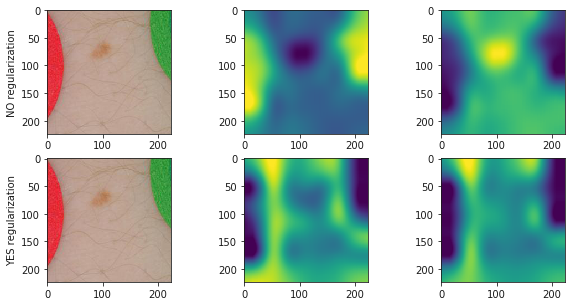

In [185]:
fig, axes = plt.subplots(ncols =3, nrows =2 ,figsize = (10, 5))
axes[0,0].imshow(img_np[50:274, 50:274])
model.classifier.load_state_dict(torch.load('../skin_cancer/feature_models/73007178261481664335.pt'))
out_no, out_yes = get_grad_cam(model, img_np)
axes[0,1].imshow(out_no)
axes[0,2].imshow(out_yes)
axes[0,0].set_ylabel("NO regularization")
axes[1,0].imshow(img_np[50:274, 50:274])

model.classifier.load_state_dict(torch.load('../skin_cancer/feature_models/65522666016212743206.pt'))
model
out_no, out_yes = get_grad_cam(model, img_np)
axes[1,1].imshow(out_no)
axes[1,2].imshow(out_yes)
axes[1,0].set_ylabel("YES regularization")
# GradCAM agrees that this is good

In [186]:
torch_img = torch.from_numpy(((img_np - mean)/std).swapaxes(0,2).swapaxes(1,2)).float()
model(torch_img[None, :])

tensor([[27.4912, -4.7348]], grad_fn=<AddmmBackward>)

In [187]:
model.classifier.load_state_dict(torch.load('../skin_cancer/feature_models/73007178261481664335.pt'))
torch_img = torch.from_numpy(((img_np - mean)/std).swapaxes(0,2).swapaxes(1,2)).float()
model(torch_img[None, :])

tensor([[ 16.8956, -17.4759]], grad_fn=<AddmmBackward>)